# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

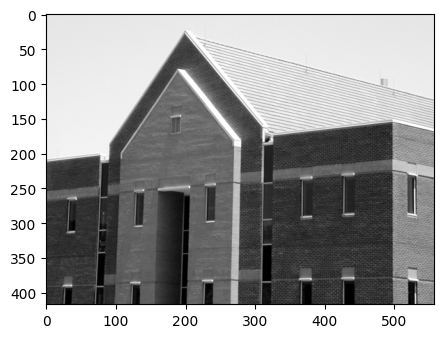

(417, 557)


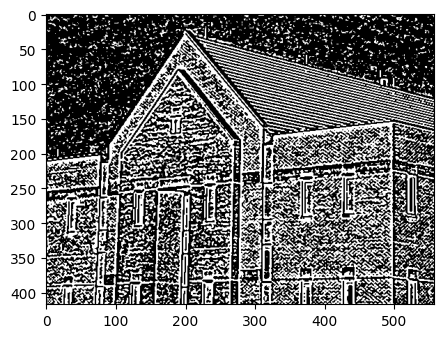

(417, 557)


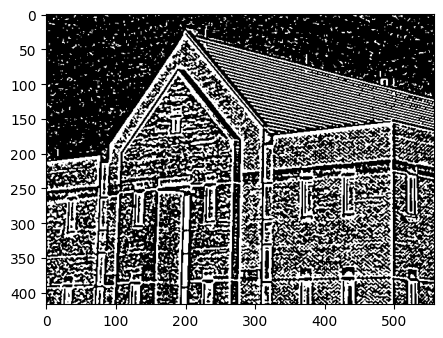

(417, 557)


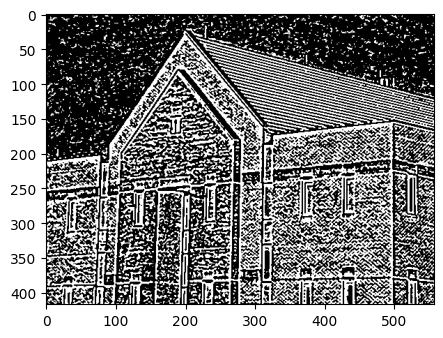

(417, 557)


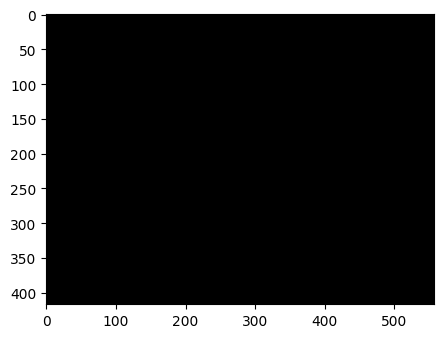

(417, 557)


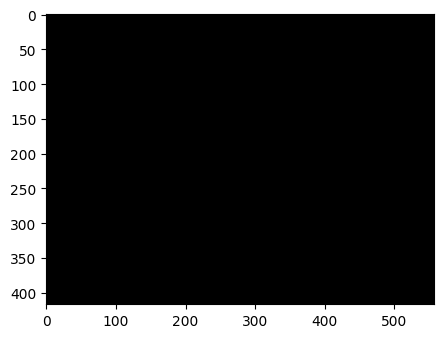

In [46]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import requests

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/'

fileNames = ["dom.png"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)

def show_all(images = [], vertical = False):
    def append_plot(ax, image):
        ax.imshow(image, 'gray')

    n = len(images)
    shorter_side = 10
    longer_side = 5 * len(images)

    if vertical:
        fig, axs = plt.subplots( n, 1 )
        fig.set_size_inches(shorter_side, longer_side)
    else:
        fig, axs = plt.subplots( 1, n )
        fig.set_size_inches(longer_side, shorter_side)


    if len(images) == 1:
        image = images[0]
        append_plot(axs, image)
    else:
        for i in range(len(images)):
            image = images[i]
            append_plot(axs[i], image)
    plt.show()

def open_image(path, gray = True):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY if gray else cv2.COLOR_BGR2RGB)
    return image


def crossing(log, thr, window_size = 3):
    result_image = np.zeros(log.shape)
    print(result_image.shape)
    for i in range(window_size // 2, log.shape[0] - window_size // 2):
        for j in range(window_size // 2, log.shape[1] - window_size // 2):
            # print(i - 1, i + 1, j - 1, j + 1)
            window = log[i - 1: i + 2, j - 1 : j + 2]
            # print(window)
            min_window = np.min(window)
            max_window = np.max(window)

            if max_window * min_window < 0:
                if log[i, j] > 0:
                    result_image[i, j] = log[i,j] + np.abs(min_window)
                else:
                    result_image[i,j] = np.abs(log[i,j]) + max_window
    
    # binarized = np.zeros(log.size)

    binarized = log >= thr
    binarized = binarized * 255
    binarized = binarized.astype('uint8')

    return cv2.medianBlur(binarized, window_size)

def laplacian_of_gaussian(image, threshold = 1, window_size = 3, standard_deviation = 0):
    gaussian = cv2.GaussianBlur(image, (window_size, window_size), standard_deviation)
    log = cv2.Laplacian(gaussian, cv2.CV_32F)
    crossed = crossing(log, threshold)
    show_all([crossed])


image_home = open_image('dom.png')
show_all([image_home])

laplacian_of_gaussian(image_home)
laplacian_of_gaussian(image_home, 1, 5, 1)
laplacian_of_gaussian(image_home, 1, 3, 1)
laplacian_of_gaussian(image_home, 80, 3, 5)
laplacian_of_gaussian(image_home, 70, 3, 10)

(417, 557)


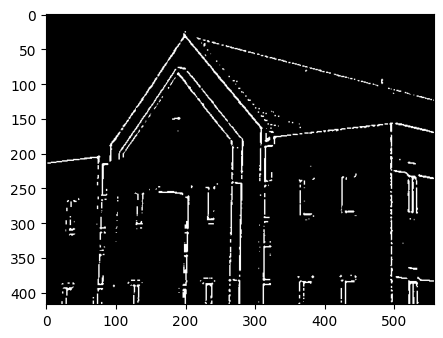

In [47]:
laplacian_of_gaussian(image_home, threshold=7, window_size=5, standard_deviation=1.45)


## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w 1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj algorytm detekcji krawędziCanny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:

- [$-22.5^\circ, 22.5^\circ$], 
- [$22.5^\circ, 67.5^\circ$],
- [$67.5^\circ, 112.5^\circ$], 
- [$112.5^\circ, 157.5^\circ$],
- [$157.5^\circ, -157.5^\circ$], 
- [$-157.5^\circ, -112.5^\circ$],
- [$-112.5^\circ, -67.5^\circ$], 
- [$-67.5^\circ, -22.5^\circ$].

Przy czym należy rozpatrywać tylko 4 kierunki:
- pionowy ($d_1$),
- poziomy ($d_2$),
- skośny lewy ($d_3$),
- skośny prawy ($d_4$).

5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
Często krawędzie "pewne" nie są ciągłe.
Dlatego wykorzystuje się obraz $g_{NL}$ w następującej procedurze:
    - Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g_{NH}$.
W tym celu wykorzystaj listę współrzędnych `[row, col]`.
Do pobrania elementu z początku służy metoda `list.pop()`.
Do dodania elementu na koniec listy służy metoda `list.append(new)`.
    - Stwórz obraz, który będzie zawierał informację czy dany piksel został już odwiedzony.
    - Stwórz obraz, któy zawierać będzie wynikowe krawędzie.
Jej rozmiar jest równy rozmiarowi obrazu.
    - Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
W tym celu najlepiej sprawdzi się pętla `while`.
    - W każdej iteracji pobierz element ze stosu.
    - Sprawdź czy dany element został już odwiedzony.
    - Jeśli nie został, to:
        - Oznacz go jako odwiedzony,
        - Oznacz piksel jako krawędź w wyniku,
        - Sprawdź otoczenie piksela w obrazie $g_{NL}$,
        - Dodaj do stosu współrzędne otoczenia, które zawierają krawędź (potencjalną).
        Można to wykoanać np. pętlą po stworzonym otoczeniu.
7. Wyświetl obraz oryginalny, obraz $g_{NH}$ oraz obraz wynikowy.

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować wbardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj algorytm Cannego.

In [48]:
from collections import deque

#### CONSTANTS ####

neighbours = [
    [(1,0), (1,1), (1,2)], # =
    [(0,1), (1,1), (2,1)], # |
    [(2,0), (1,1), (0,2)], # /
    [(0,0), (1,1), (2,2)], # \
]
step = np.pi / 8

directions = [
    [(-step, step), (np.pi - step, np.pi), (-np.pi, -np.pi + step)],    # - -> -
    [(3 * step, np.pi - 3 * step), ( -np.pi + 3 * step , -3 * step)],   # | -> |
    [(np.pi - 3 * step, np.pi - step), (- 3 * step, - step)],           # / -> /
    [(step, 3 * step), (-np.pi + step, -np.pi + 3 * step)],             # \ -> \
]

def get_direction(angle):
    global directions
    for dir in range(len(directions)):
        for start, end in directions[dir]:
            if start <= angle <= end:
                return dir
    return -1

### FILTERS ###

S1 = np.array([
  [-1, 0, 1],
  [-2, 0, 2],
  [-1, 0, 1],
], dtype=np.float64)

S2 = np.array([
  [-1, -2, -1],
  [ 0,  0,  0],
  [ 1,  2,  1],
], dtype=np.float64)

def use_filter(image, kernel):
    return cv2.filter2D(src=image.astype(float), ddepth=-1, kernel=kernel)

# This functions return a aplitude of the image using sobel filtering method
def get_amplitude(image):
    global S1, S2
    gradient_x = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=3)
    gradient_y = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=3)

    # gradient_x = use_filter(image, S1)
    # gradient_y = use_filter(image, S2)
    return np.sqrt(( gradient_x ** 2 + gradient_y ** 2)), np.arctan2(gradient_y, gradient_x)

def is_between(value, rng):
    return rng[0] <= value < rng[1]
    
def get_directions(angles):
    global directions
    result = np.zeros_like(angles)
    for i in range(angles.shape[0]):
        for j in range(angles.shape[1]):
            result[i,j] = get_direction(angles[i,j])
    return result.astype('uint8')

def process_window(dirs, amplitudes):
    global neighbours
    middle_i = dirs.shape[0] // 2
    middle_j = dirs.shape[1] // 2

    direction = dirs[middle_i, middle_j]
    candidates = neighbours[direction]

    max_v = amplitudes[middle_i, middle_j]
    for row, col in candidates:
        max_v = max(max_v, amplitudes[row, col])

    if max_v != amplitudes[middle_i, middle_j]:
        return 0
    return amplitudes[middle_i, middle_j]

# nonmax
def eliminate_pixels(dirs, amplitude):
    result = np.zeros(dirs.shape)

    for i in range(1, dirs.shape[0] - 1):
        for j in range(1, dirs.shape[1] - 1):
            sub_dirs = dirs[i - 1: i + 2, j - 1: j + 2]
            sub_amplitude = amplitude[i - 1: i + 2, j - 1: j + 2]

            result[i,j] = process_window(sub_dirs, sub_amplitude)

    return result

def get_all_true_coords(image):
    result = deque()
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            if image[row,col]:
                result.append((row,col))
    return result

def canny_binarization(gradient_nh, gradient_nl):
    stack = get_all_true_coords(gradient_nh)
    visited = gradient_nh != gradient_nh

    result = np.zeros(gradient_nh.shape)

    while stack:
        row, col = stack.pop()
        if visited[row, col]:
            continue

        visited[row, col] = True

        result[row, col] = True
        
        for i in range(row - 1, row + 2):
            for j in range(col - 1, col + 2):
                if not gradient_nl[i, j]:
                    continue

                if i == row and j == col:
                    continue
                
                stack.append((i, j))

    return result

def canny(image, th = 15, tl = 7, window_size = 5, standard_deviation = 1.45, show = True):
    image_filtered = cv2.GaussianBlur(image, (window_size, window_size), standard_deviation)

    amplitudes, angles = get_amplitude(image_filtered)
    dirs = get_directions(angles)
    eliminated = eliminate_pixels(dirs, amplitudes)

    gradient_nh = (eliminated >= th)
    gradient_nl = (th > eliminated) & (eliminated >= tl)
    
    if show:
        show_all([ eliminated, gradient_nh * 255, gradient_nl * 255])

    result = canny_binarization(gradient_nh, gradient_nl)
    return result

### TESTS ###

# for neighbour in neighbours:
#     print()
#     r = [[0 for _ in range(3)] for _ in range(3)]
#     for row, col in neighbour:
#         r[row][col] = 1
#     for rrr in r:
#         print(rrr)

# for i in range(18):
#     angl = -np.pi + i * step
#     print(get_direction(angl), angl, angl * 180/ np.pi)



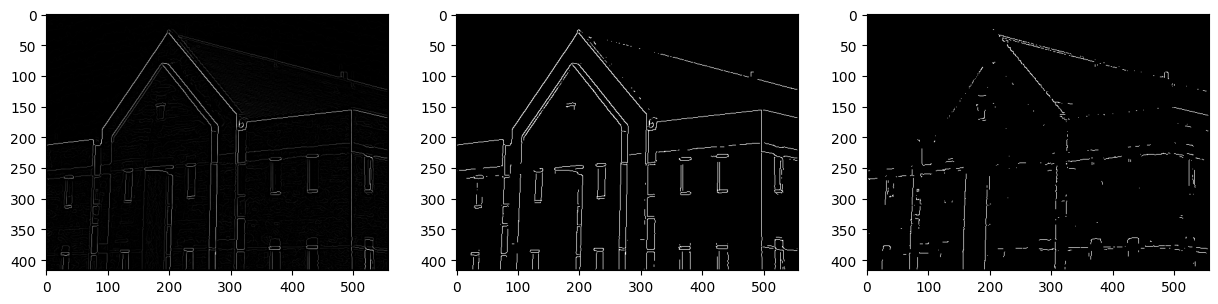

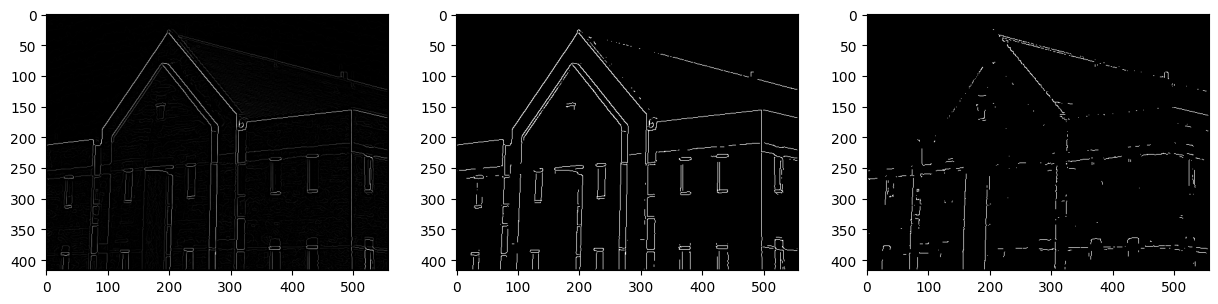

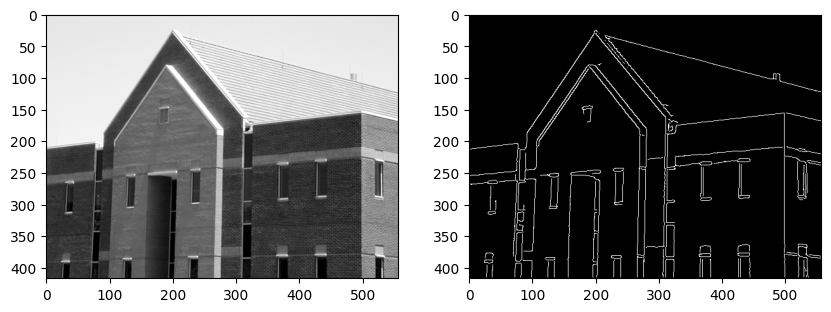

In [49]:
image_own_canny = canny(image_home, th = 80, tl = 40, window_size=7, standard_deviation=1.5)
show_all([
    image_home,
    canny(image_home, th = 80, tl = 40, window_size=7, standard_deviation = 1.5)
])

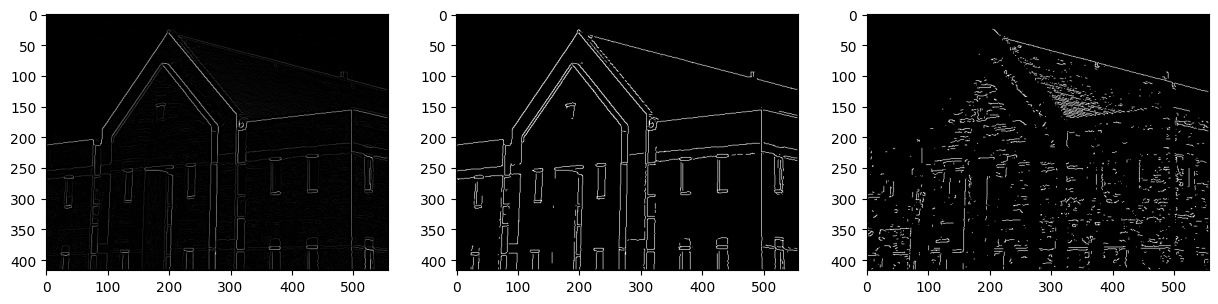

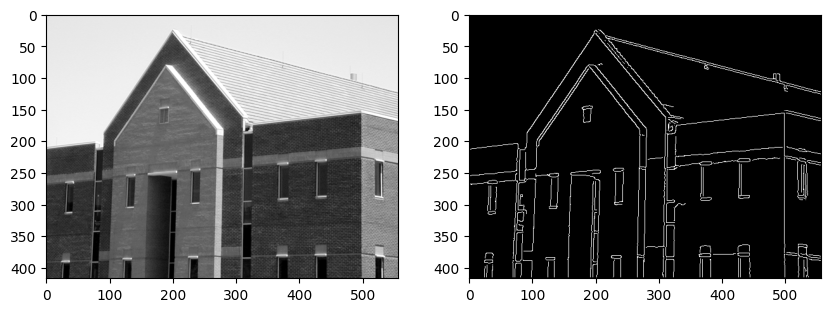

In [50]:
show_all([
    image_home,
    canny(image_home, th = 60, tl = 20, window_size=7, standard_deviation=1.5)
])


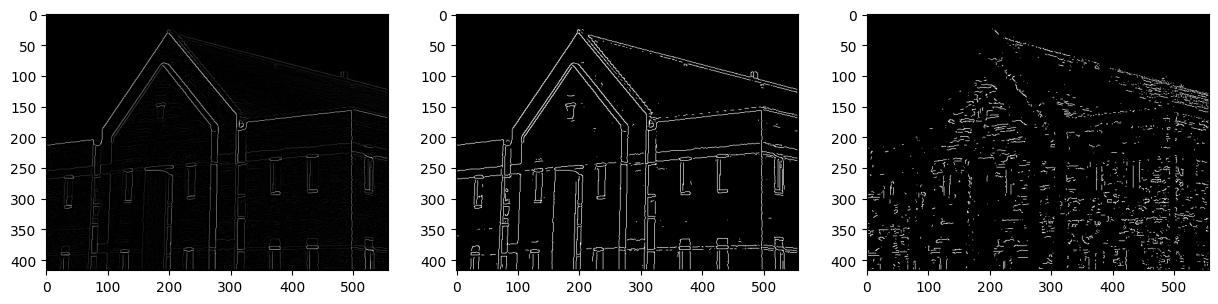

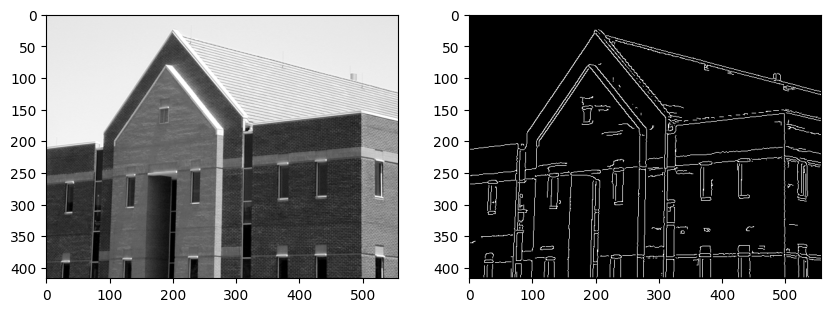

In [51]:
show_all([
    image_home,
    canny(image_home, th = 40, tl = 20, window_size=5, standard_deviation=2)
])

## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z własną implementacją.

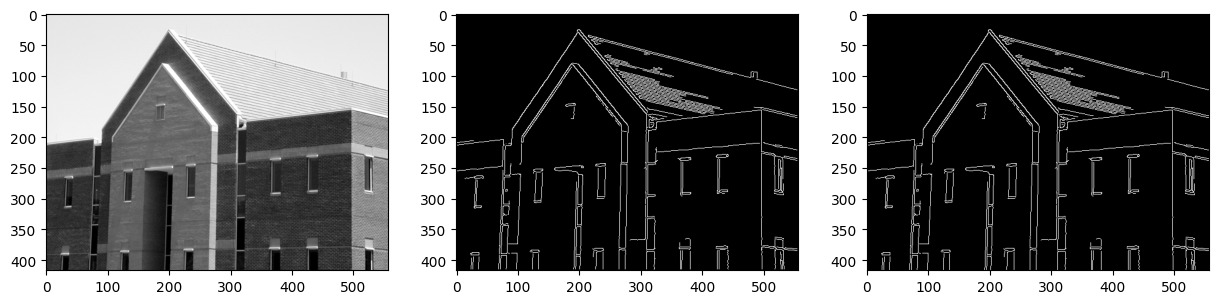

In [62]:
thr_low = 75
thr_high = 150
window_size = 3
sigma = 1.7
show_all([
    image_home,
    canny(image_home, thr_high, thr_low, window_size, sigma, show=False ),
    cv2.Canny(
        cv2.GaussianBlur(image_home, (window_size, window_size), sigma),
        thr_low,
        thr_high,
        None,
        3,
        1
    )
])